In [18]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import cv2

from timeit              import default_timer as timer
from numpy.linalg        import inv
from skimage             import img_as_float

from scipy.optimize import minimize

%matplotlib inline

We'll look at $nxm$ images. We make a meshgrid of pixel coordinates. Then we make it into a long vector.

In [ ]:
n = 28
m = 28

rx, ry = np.arange(0,n, 1), np.arange(0,m, 1)
gx, gy = np.meshgrid(rx, ry) 

# Pair up elems from gx and gy to create array of pairs 
X_2D = np.c_[gx.ravel(), gy.ravel()]

Define the kernel matrix

In [ ]:
def kernel(X1, X2, l=1, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    Args:
        X1: Array of m points (m x d).  We'll have d=1 or 2. For images we have d = 2.
        X2: Array of n points (n x d).
        l : lenght-scale, default is 1
        sigma_f: vertical variation, default is 1
    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-(1/(2*l**2)) * sqdist)

**We will first illustrate small variance**

In [ ]:
l = 2

#deformation
X = np.c_[gx.ravel()+5.5, gy.ravel()-7.8] #eg shift x and y coordinates by certain fixed amount

K = kernel(X,X_2D, l)
plt.imshow(K, cmap = 'jet')
plt.colorbar();

# A Gaussian mixture:

Take a couple of coefficients

In [ ]:
a = np.zeros((n,m))
a[6:15,6:22] = 1
a[8:13,8:20] = 0
a[22:24,22:24] = 4
plt.imshow(a, cmap = 'gray');

Make linear combination of Gaussians centred at the position of those coefficients

In [ ]:
Mix = K@a.ravel()

plt.imshow(Mix.reshape(a.shape[0],a.shape[1]), cmap = 'gray');

... and get the coefficients back:

In [ ]:
coeff = np.linalg.pinv(K)@Mix

plt.imshow(coeff.reshape(n,m), cmap = 'gray');

## Now getting the best Gaussian mixture approximation of an image

Here's the image

In [ ]:
img_raw = cv2.imread('img_6.jpg',0)
img = img_as_float(img_raw) 
#img = denoise_tv_chambolle(img,weight=0.1) # TV denoise
plt.imshow(img, cmap = 'jet')
plt.title("true image")
plt.colorbar();

Here are the least squares solution coefficients

In [ ]:
coeff = np.linalg.pinv(K)@img.ravel()

plt.imshow(coeff.reshape(n,m), cmap = 'jet')
plt.title("Coefficients")
plt.colorbar();

Here is the approximation:

In [ ]:
Approx = K@coeff

plt.imshow(Approx.reshape(a.shape[0],a.shape[1]), cmap = 'jet')
plt.title("Gaussian mixture approximation")
plt.colorbar();

Difference between true image and Gaussian mixture approximation:

In [ ]:
plt.imshow(img - Approx.reshape(a.shape[0],a.shape[1]), cmap = 'jet')
plt.title("Difference between truth and approximation")
plt.colorbar();

## Now here is for larger variance:

In [ ]:
l = 6.5
K = kernel(X,X_2D, l)
plt.imshow(K, cmap = 'jet')
plt.colorbar();

In [ ]:
coeff = np.linalg.pinv(K)@img.ravel()

plt.imshow(coeff.reshape(n,m), cmap = 'jet')
plt.title("Coefficients")
plt.colorbar();

In [ ]:
Approx = K@coeff

plt.imshow(Approx.reshape(a.shape[0],a.shape[1]), cmap = 'jet')
plt.title("Gaussian mixture approximation")
plt.colorbar();

In [ ]:
plt.imshow(img - Approx.reshape(a.shape[0],a.shape[1]), cmap = 'jet')
plt.title("Difference between truth and approximation")
plt.colorbar();

# Implementation of the $\alpha$-equation for kernels including deformation.

In [2]:
n = 28
m = 28

rx, ry = np.arange(0,n, 1), np.arange(0,m, 1)
gx, gy = np.meshgrid(rx, ry) 
# Pair up elems from gx and gy to create array of pairs 
X_2D = np.c_[gx.ravel(), gy.ravel()]

In [3]:
def kernel(X1, X2, l=1, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    Args:
        X1: Array of m points (m x d).  We'll have d=1 or 2. For images we have d = 2.
        X2: Array of n points (n x d).
        l : lenght-scale, default is 1
        sigma_f: vertical variation, default is 1
    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-(1/(2*l**2)) * sqdist)

Consider the following coefficients and the corresponding template:

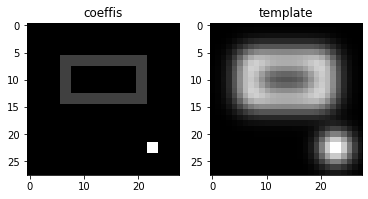

In [4]:
a = np.zeros((n,m))
a[6:15,6:22] = 1
a[8:13,8:20] = 0
a[22:24,22:24] = 4

Mix = kernel(X_2D,X_2D,2)@a.ravel()

plt.subplot(1,2,1)
plt.imshow(a, cmap = 'gray');
plt.title("coeffis")
plt.subplot(1,2,2)
plt.imshow(Mix.reshape(a.shape[0],a.shape[1]), cmap = 'gray');
plt.title("template");

Suppose y1 and y2 are two versions of the template with different (**non-integer**) shifts as deformation, say

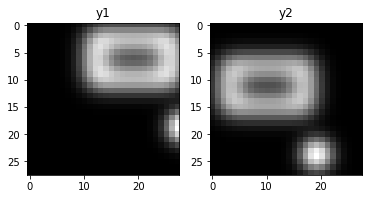

In [5]:
K1 = kernel(X_2D,np.c_[gx.ravel()+5.5, gy.ravel()-3.8],2)
y1 = K1@a.ravel()

K2 = kernel(X_2D,np.c_[gx.ravel()-3.5, gy.ravel()+1.2],2)
y2 = K2@a.ravel()

plt.imshow(y1.reshape(a.shape[0],a.shape[1]), cmap = 'gray');

plt.subplot(1,2,1)
plt.imshow(y1.reshape(a.shape[0],a.shape[1]), cmap = 'gray');
plt.title("y1")
plt.subplot(1,2,2)
plt.imshow(y2.reshape(a.shape[0],a.shape[1]), cmap = 'gray');
plt.title("y2");

Then we can implement the $\alpha$ equation like so (note that for an invertible matrix its inverse and pseudo-inverse coincide, but calculating the pseudo-inverse is numerically much more stable if there are many values that are almost zero, like in our case) :

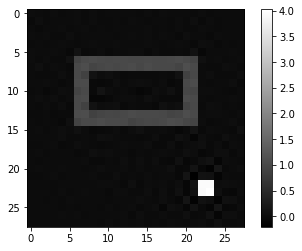

In [6]:
alpha = np.linalg.pinv( K1.T@K1 + K2.T@K2 ) @ ( K1.T@y1 + K2.T@y2 )

plt.imshow(alpha.reshape(n,m), cmap = 'gray')
plt.colorbar();

**Note:** 
* A way to make this faster for large matrices would perhaps come from not calculationg all the zeros in the above alpha calculation. For instance, K1.T@y1 can perhaps be implemented via a convolution (with small kernel and using the fft implementation of the convolution). 

* The matrix that has to be inverted is of the dimension (#centres)x(#centres), so it can be kept smaller that the image dimension. 

* Without using a mathematical trick like the fft convolution and/or avoiding calculating so many essentially zero values, I doubt that there is an obvious more efficient implementation for the above.

# Gradient descent

In [7]:
n = 28
m = 28

rx, ry = np.arange(0,n, 1), np.arange(0,m, 1)
gx, gy = np.meshgrid(rx, ry) 
# Pair up elems from gx and gy to create array of pairs 
X_2D = np.c_[gx.ravel(), gy.ravel()]

Here is a test beta

In [25]:
rx, ry = np.random.normal(loc=0.0, scale=1.8, size=n), np.random.normal(loc=0.0, scale=1.8, size=m)
bx, by = np.meshgrid(rx, ry) 
# Pair up elems from gx and gy to create array of pairs 
B_2D = np.c_[bx.ravel(), by.ravel()]

B_2D

array([[ 1.6733269 , -2.34472992],
       [ 0.09305318, -2.34472992],
       [ 4.58552607, -2.34472992],
       ...,
       [-0.94966671, -0.15851695],
       [ 2.2286906 , -0.15851695],
       [-0.59009858, -0.15851695]])

Synthetic data to test gradient descent

0.03774220000013884


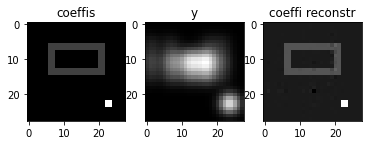

In [23]:
a = np.zeros((n,m))
a[6:15,6:22] = 1
a[8:13,8:20] = 0
a[22:24,22:24] = 4

start = timer()
kBp = kernel(X_2D,X_2D - B_2D,2)
end = timer()   

print(end - start)
y = kBp@a.ravel()

plt.subplot(1,3,1)
plt.imshow(a, cmap = 'gray');
plt.title("coeffis")
plt.subplot(1,3,2)
plt.imshow(y.reshape(a.shape[0],a.shape[1]), cmap = 'gray');
plt.title("y");
plt.subplot(1,3,3)
plt.imshow((np.linalg.pinv(kBp)@y).reshape(a.shape[0],a.shape[1]), cmap = 'gray');
plt.title("coeffi reconstr");

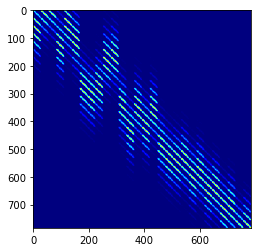

In [16]:
plt.imshow(kBp, cmap = 'jet');

Gradient descent to find the minimizer of
$$
f(\beta) =  \frac{1}{2}\| y - K_p^{\beta} a\|^2
$$



In [114]:
# THis is to slow to even do one iteration.
def f(beta):
        kBp = kernel(X_2D,X_2D - beta.reshape(28**2,2),2)
        return 0.5 * np.linalg.norm(y - kBp@a.ravel())**2
beta_init = 0*B_2D.ravel()
scipy.optimize.fmin_cg(f,beta_init, maxiter = 1)

So we have to calculate the gradient: 
$$
\nabla f (\beta) = ..  y - K_p^{\beta}a
$$